# Détectez des faux billets 

### 1 Import des librairies

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from ydata_profiling import ProfileReport
from scipy.stats import chi2_contingency
import numpy as np
import os

### 1-1 Import de base pour le ML

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### 1-2 Imports des modèles demandés

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

### 1-3 Imports pour les métriques

In [9]:
from sklearn.metrics import (
    confusion_matrix,#Analyse faux positifs/faux négatifs
    classification_report,
    accuracy_score,
    roc_auc_score,
    roc_curve
)#Compare les modeles

### 1-4 Eviter un encombrement du NB

In [11]:
import warnings
warnings.filterwarnings("ignore")

### 2 EDA

In [13]:
def analyse_exploratoire(df, nom_dataset="Dataset"):
    print(f"\n==== Analyse Exploratoire : {nom_dataset} ====\n")
    
    # Dimensions
    print("Dimensions :")
    print(df.shape)
    
    # Types des colonnes et valeurs manquantes
    print("\nTypes et valeurs manquantes :")
    print(df.dtypes)
    print("\nAperçu :")
    display(df.head())
    print("\nPourcentage de valeurs manquantes :\n", df.isnull().mean() * 100)
    
    # Unicité pour les colonnes object (s'il y en a)
    cat_cols = df.select_dtypes(include='object').columns
    if len(cat_cols) > 0:
        print("\nUnicité des variables catégorielles :")
        for col in cat_cols:
            print(f"Valeurs uniques pour {col} :", df[col].nunique())
    else:
        print("\nAucune variable catégorielle (type object).")
        
    # Statistiques descriptives numériques
    print("\nStats descriptives numériques :")
    if df.select_dtypes(include=np.number).shape[1] > 0:
        display(df.describe().T)
    else:
        print("Aucune variable numérique.")
    
    # Statistiques descriptives catégorielles (uniquement si object)
    if len(cat_cols) > 0:
        print("\nStats descriptives catégorielles :")
        display(df[cat_cols].describe(include=['object']).T)
    else:
        print("\nPas de stats descriptives catégorielles : pas de colonnes object.")
    
    # Visualisation valeurs manquantes
    print("\nVisualisation des valeurs manquantes :")
    msno.matrix(df)
    plt.show()
    msno.heatmap(df)
    plt.show()

    # Outliers (boxplots) pour variables numériques
    num_cols = df.select_dtypes(include='number').columns
    for col in num_cols:
        series = df[col].dropna()
        if len(series) > 0:
            plt.figure()
            sns.boxplot(x=series)
            plt.title(f'Boîte à moustaches - {col}')
            plt.show()
    
    # Matrice de corrélation
    num_df = df.select_dtypes(include=np.number)
    print("\nMatrice de corrélation :")
    if num_df.shape[1] == 0:
        print("Pas de colonnes numériques disponibles pour la corrélation.")
    else:
        corr = num_df.corr()
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
        plt.title("Matrice de Corrélation")
        plt.show()

    # Table de contingence & test Chi2 pour colonnes catégorielles (si au moins 2)
    if len(cat_cols) >= 2:
        print("\nTest du Chi2 sur 2 variables catégorielles :")
        table = pd.crosstab(df[cat_cols[0]], df[cat_cols[1]])
        chi2, p, dof, expected = chi2_contingency(table)
        print(f"Test du Chi2 entre {cat_cols[0]} et {cat_cols[1]} :")
        print("Statistique chi2 :", chi2, "p-value :", p)
        display(table)
    else:
        print("\nPas assez de variables catégorielles pour un test du Chi2.")
    
    # Profilage automatique ydata_profiling
    print("\nGénération du rapport de profilage (ydata_profiling) :")
    try:
        profile = ProfileReport(df, title=f"Profilage {nom_dataset}", explorative=True)
        profile.to_file(f"profil_{nom_dataset}.html")
        print(f"Rapport sauvegardé : profil_{nom_dataset}.html")
    except Exception as e:
        print("Profilage automatique indisponible :", e)
    
    print("\n" + "=" * 60)

In [14]:
#Import du df
df=pd.read_csv(r"D:\Users\Utilisateur\Documents\Maryline\Formation Data Analyst\P12- Machine learning\billets.csv",sep=";")


==== Analyse Exploratoire : Machine learning_les billets ====

Dimensions :
(1500, 7)

Types et valeurs manquantes :
is_genuine         bool
diagonal        float64
height_left     float64
height_right    float64
margin_low      float64
margin_up       float64
length          float64
dtype: object

Aperçu :


,is_genuine,diagonal,height_left,height_right,margin_low,margin_up,length
0,True,171.81,104.86,104.95,4.52,2.89,112.83
1,True,171.46,103.36,103.66,3.77,2.99,113.09
2,True,172.69,104.48,103.50,4.40,2.94,113.16
3,True,171.36,103.91,103.94,3.62,3.01,113.51
4,True,171.73,104.28,103.46,4.04,3.48,112.54



Pourcentage de valeurs manquantes :
 is_genuine      0.000000
diagonal        0.000000
height_left     0.000000
height_right    0.000000
margin_low      2.466667
margin_up       0.000000
length          0.000000
dtype: float64

Aucune variable catégorielle (type object).

Stats descriptives numériques :


,count,mean,std,min,25%,50%,75%,max
diagonal,1500.0,171.958440,0.305195,171.04,171.750,171.96,172.17,173.01
height_left,1500.0,104.029533,0.299462,103.14,103.820,104.04,104.23,104.88
height_right,1500.0,103.920307,0.325627,102.82,103.710,103.92,104.15,104.95
margin_low,1463.0,4.485967,0.663813,2.98,4.015,4.31,4.87,6.90
margin_up,1500.0,3.151473,0.231813,2.27,2.990,3.14,3.31,3.91
length,1500.0,112.678500,0.872730,109.49,112.030,112.96,113.34,114.44



Pas de stats descriptives catégorielles : pas de colonnes object.

Visualisation des valeurs manquantes :


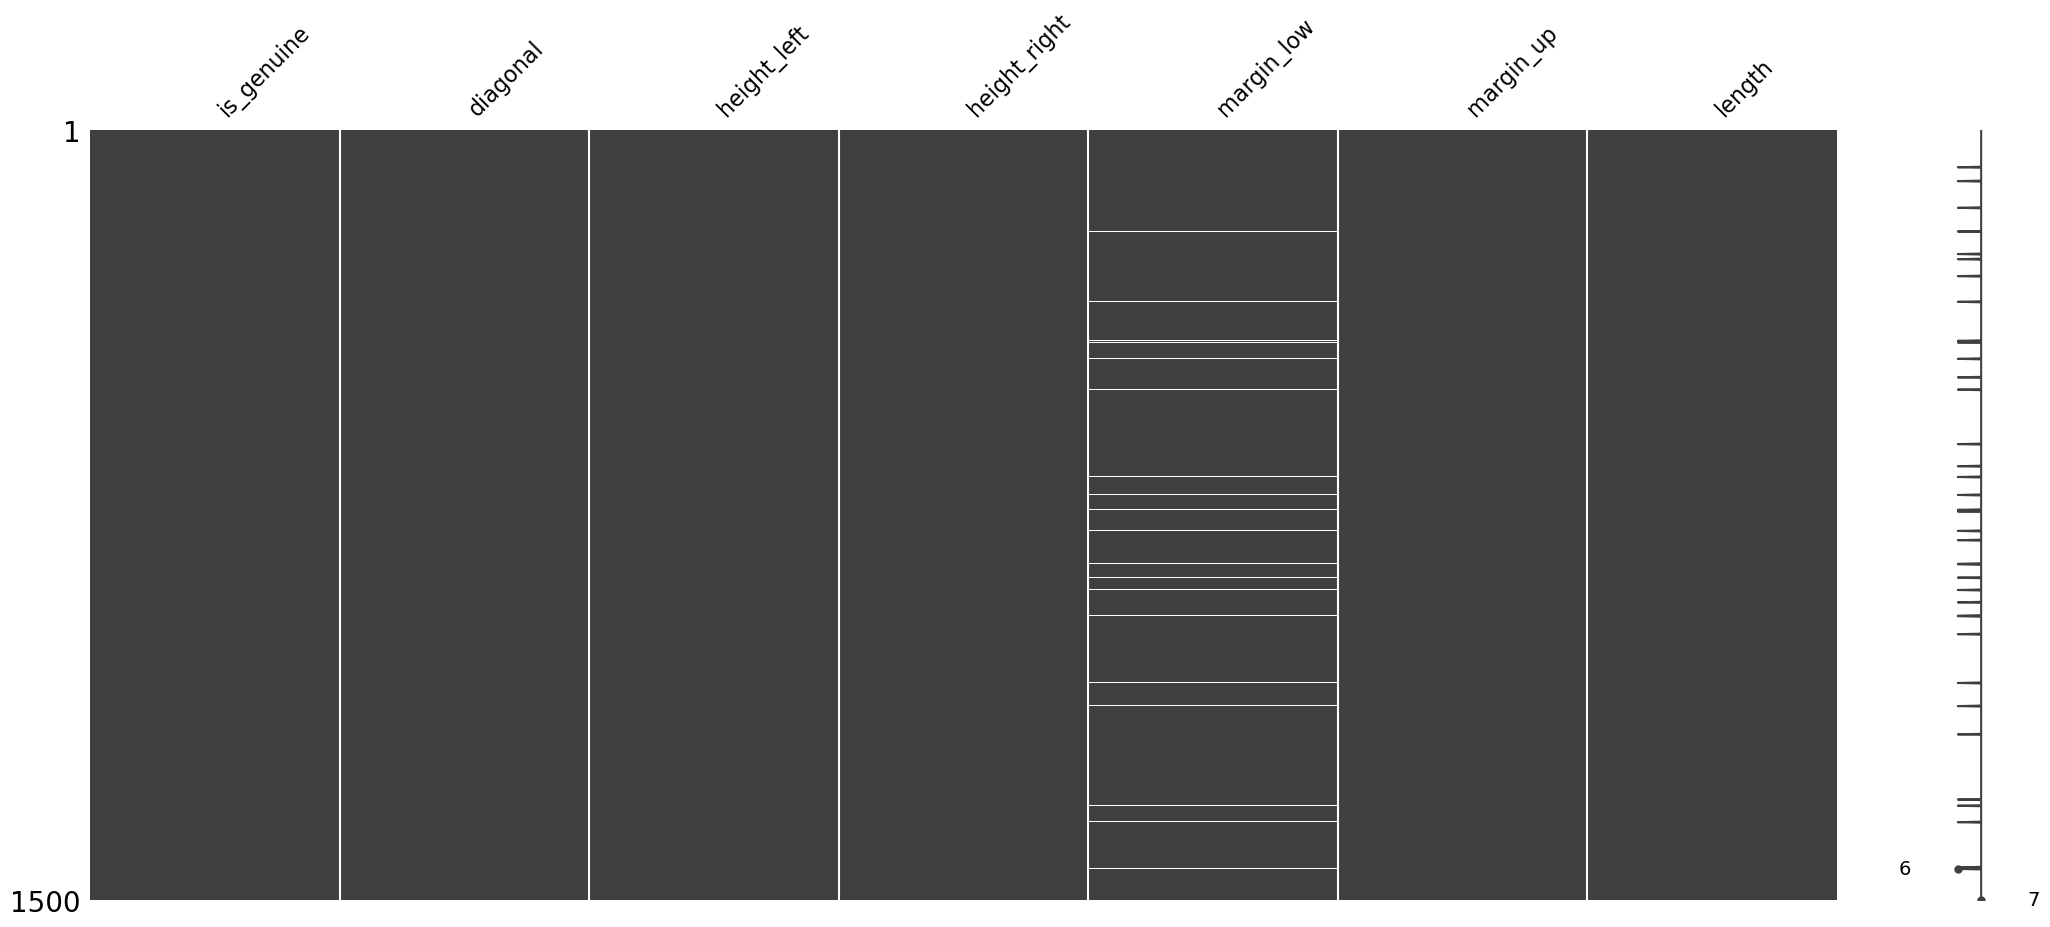

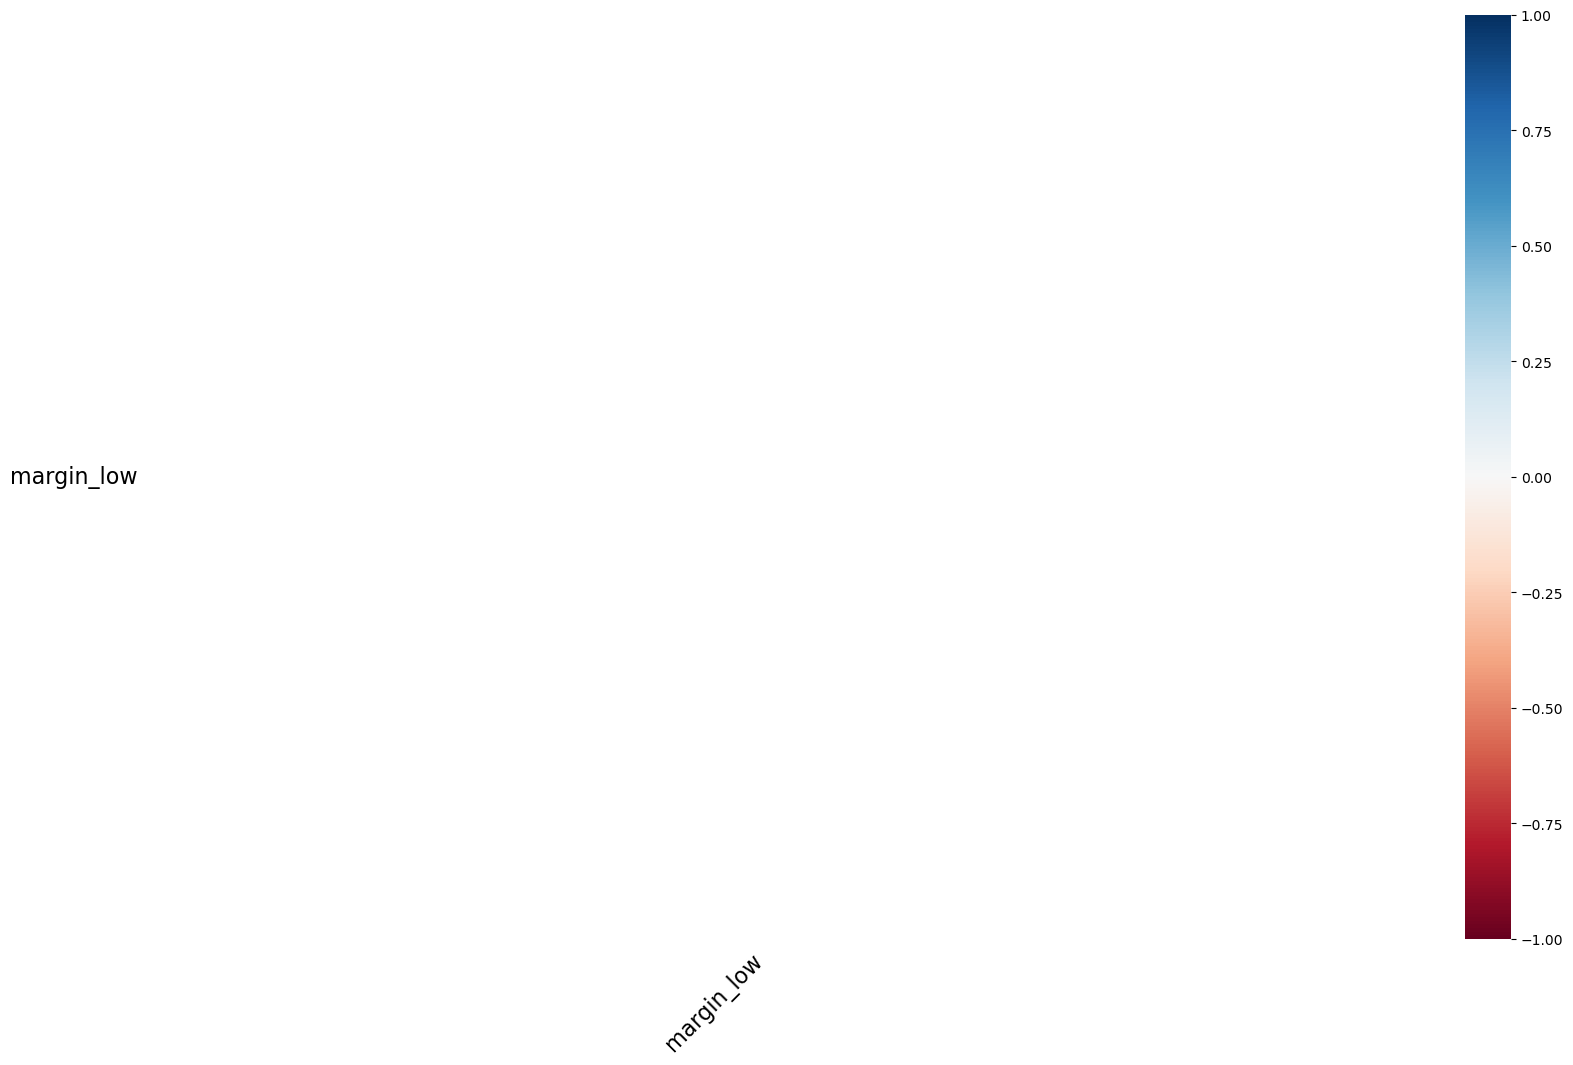

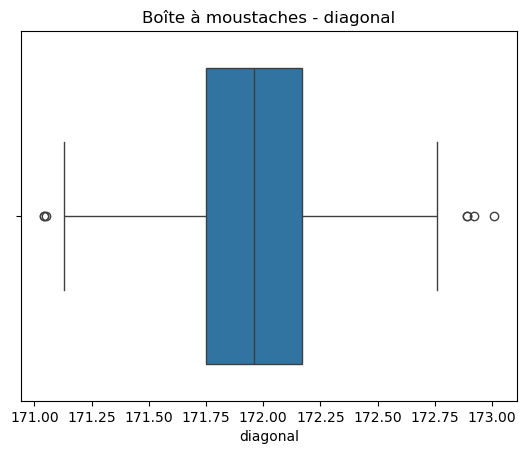

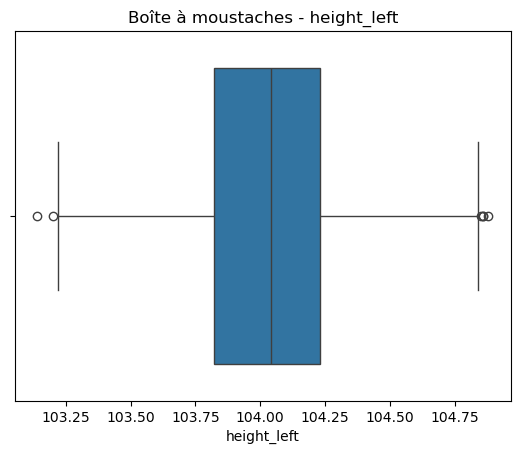

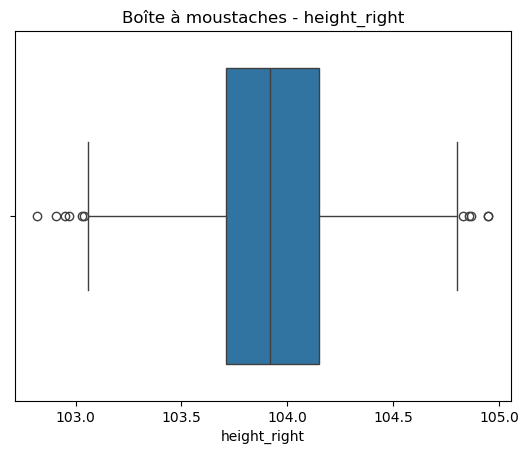

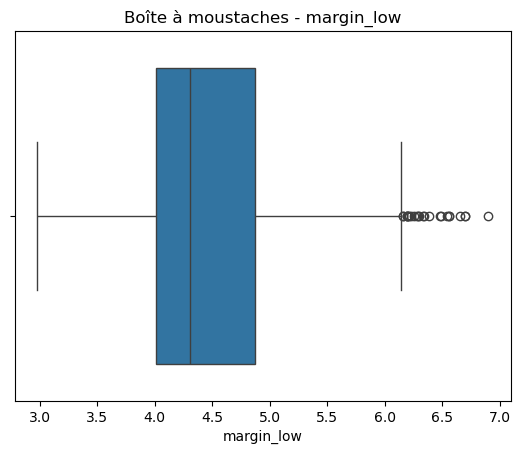

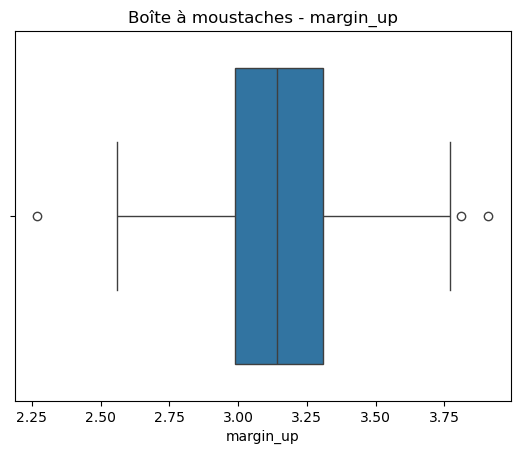

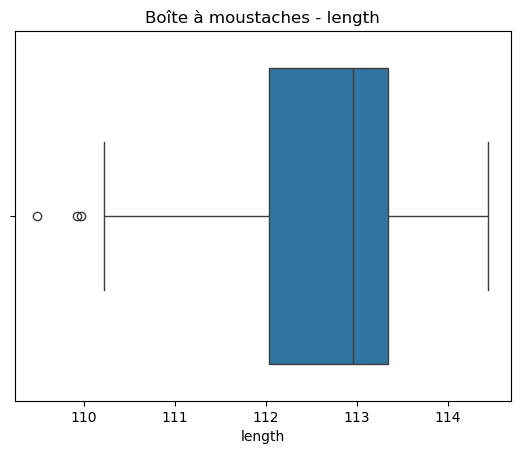


Matrice de corrélation :


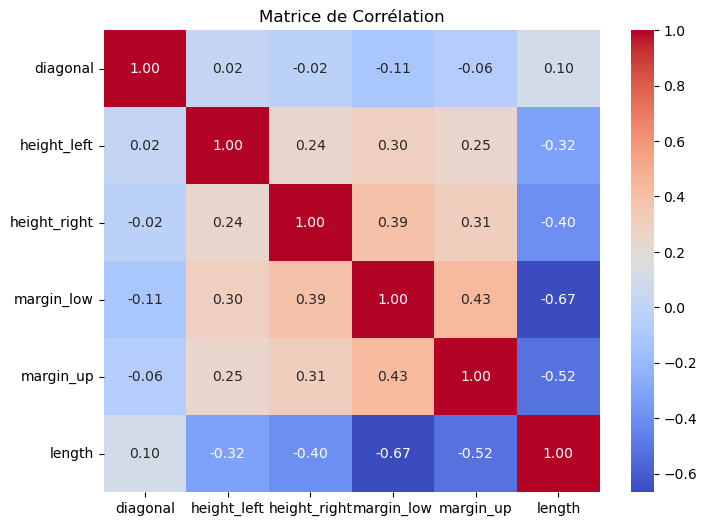


Pas assez de variables catégorielles pour un test du Chi2.

Génération du rapport de profilage (ydata_profiling) :


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]


100%|██████████| 7/7 [00:00<00:00, 41236.13it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

Rapport sauvegardé : profil_Machine learning_les billets.html



In [15]:
#Appel de la fonction
analyse_exploratoire(df, nom_dataset="Machine learning_les billets")

### 3 Prétraitement

In [17]:
#Définition de x et y
# Cible
y = df["is_genuine"]          # True / False

# Variables explicatives (toutes les colonnes sauf la cible)
X = df.drop(columns=["is_genuine"])

In [18]:
X.head()
y.value_counts()

is_genuine
True     1000
False     500
Name: count, dtype: int64

##### Nous avons bien d un coté 1000 billets vrais et 500 faux

In [20]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,#20% des données en test-80% en train
    random_state=42,
    stratify=y#permet de garder la proportion 1000 vrais/500 faux dans chaque échantillon
)

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imputed)
X_test_scaled = scaler.transform(X_test_imputed)

### 4 Modélisation

### 4.1 Régression logistique

In [24]:
#Initialisation de la régression logistique
log_reg = LogisticRegression(
    max_iter=1000,        # nombre max d'itérations
    random_state=42,      # reproductibilité
    solver="lbfgs"        # bon choix pour données de taille moyenne
)

In [25]:
#Entrainement du modèle
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=1000, random_state=42)

In [26]:
#Prédire vrai/faux sur X_test
y_pred_lr = log_reg.predict(X_test_scaled)

# Optionnel : probas
y_proba_lr = log_reg.predict_proba(X_test_scaled)[:, 1]

In [27]:
#Evaluation du modèle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("Accuracy Régression logistique :", accuracy_score(y_test, y_pred_lr))

print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_lr))

print("\nClassification report :")
print(classification_report(y_test, y_pred_lr))

Accuracy Régression logistique : 0.99

Matrice de confusion :
[[ 98   2]
 [  1 199]]

Classification report :
              precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



##### Analyse de la matrice de confusion : 98_2= 98 vrais négatifs et 2 faux positifs soit 98 billets faux bien détectés comme faux et 2 faux billets predits à tort comme vrais
##### 1_199 : 1 faux négatifs=1 vrai billet prédit à tort comme faux et 199 vrais positifs= 199 vrais billets prédits comme vrais
##### Analyse des métriques: Accuracy=0.99= 99% des 300 billets du test sont correctement classés soit 297/300, classe false ( faux billets) precision 99%, c'est a dire lorsque le billet est faux il est prédit à 99 % du temps. Recall 098= il recupère 98% de tous les faux billets présents dans le test.
##### Classe true(vrais billets): precision 0.99 et recall 0.99 presque aucun billet n'est pris pour un faux ou inversement. F1-scores(0.98-0.99) équilibre casi parfait entre précision et recall pour chaque classe.


### 4.2 KNN

In [30]:
#Initialiser KNN
knn = KNeighborsClassifier(
    n_neighbors=5,   # à ajuster ensuite (3,5,7,…)
    metric="minkowski",
    p=2              # distance euclidienne
)

In [31]:
#Entrainer le modele
knn.fit(X_train_scaled, y_train)

KNeighborsClassifier()

In [32]:
#Prédire sur X_test
y_pred_knn = knn.predict(X_test_scaled)

In [33]:
#Evaluation du modèle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("Accuracy KNN :", accuracy_score(y_test, y_pred_knn))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred_knn))
print("\nClassification report :\n", classification_report(y_test, y_pred_knn))

Accuracy KNN : 0.9833333333333333

Matrice de confusion :
 [[ 97   3]
 [  2 198]]

Classification report :
               precision    recall  f1-score   support

       False       0.98      0.97      0.97       100
        True       0.99      0.99      0.99       200

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300



##### Analyse de la matrice= false(faux billets) 97  bien détectes comme faux, et 3 faux billets pris pour des vrais (faux positifs).True ( vrais billets) 2 vrais billets pris pour des faux et 198 bien détectés comme des vrais.
##### Par rapport à la régression logistique, KNN fait une erreur de plus dans chaque type.
##### Interprétation des métriques : Accuracy= 0.9833= soit envirion 98.3% des billets bien classés. moins que les 99% de la régréssion logistique(0.99).
##### Classe False( faux billets) précision= 0.98, KNN se trompe plus souvent que la regression logistique quand il prédit faux billet et recall=  0.97, il récupère 97% des faux billets, contre 98% pour la régréssion logistique.
##### Classe True: performance tres proche de la régression logistique 0.99.

### 4.3 Random Forest

In [36]:
#Initialisation de Random forest
rf = RandomForestClassifier(
    n_estimators=200,      # nombre d’arbres (100–300 en général)
    max_depth=None,       # profondeur libre 
    random_state=42,
    n_jobs=-1             # utilise tous les cœurs dispo
)

In [37]:
#Entrainement du modèle
rf.fit(X_train, y_train)      # la RF n’a pas besoin de données scalées

RandomForestClassifier(n_estimators=200, n_jobs=-1, random_state=42)

In [38]:
#Prédiction sur X_test
y_pred_rf = rf.predict(X_test)

In [39]:
#Evaluation du modèle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

print("Accuracy Random Forest :", accuracy_score(y_test, y_pred_rf))
print("\nMatrice de confusion :")
print(confusion_matrix(y_test, y_pred_rf))
print("\nClassification report :")
print(classification_report(y_test, y_pred_rf))

Accuracy Random Forest : 0.9866666666666667

Matrice de confusion :
[[ 97   3]
 [  1 199]]

Classification report :
              precision    recall  f1-score   support

       False       0.99      0.97      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.98      0.98       300
weighted avg       0.99      0.99      0.99       300



##### Analyse de random forest:False=  97 billets bien détectes comme faux et 3 faux pris pour des vrais.True= 1 vrai billet pris pour un faux et 199 vrais billets bien détectés.
##### Interprétation des métriques: Accuracy = 0.9867 ≈ 98,7%, très proche des 99% de la régression logistique,Faux billets : precision 0.99, recall 0.97, f1 = 0.98 → un peu moins bon en recall sur les faux que la régression logistique (0.98).
##### Vrais billets : precision/recall 0.99, f1 0.99, identique ou quasi-identique à la régression logistique.

### 4-4 Kmeans

##### K-means est très différent des trois autres : c’est un algorithme non supervisé, alors que régression logistique, KNN et Random Forest sont des algos supervisés de classification.
##### Il ne connaît pas la cible is_genuine lors de l’apprentissage, il cherche juste à regrouper les billets en 2 clusters “proches” géométriquement.
##### Il minimise la distance intra-cluster sans se soucier de “vrai/faux”, donc un cluster peut contenir un mélange des deux classes

### 5- Comparaison des modèles

In [44]:
from sklearn.metrics import accuracy_score, confusion_matrix

def eval_modele(nom, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()  # ordre: [[tn, fp],[fn, tp]]
    
    return {
        "Modèle": nom,
        "Accuracy": acc,
        "Faux billets bien détectés": tn,
        "Faux billets mal détectés (FP)": fp,
        "Vrais billets mal détectés (FN)": fn,
        "Vrais billets bien détectés": tp
    }

In [45]:
results_list = []

results_list.append(eval_modele("Régression logistique", y_test, y_pred_lr))
results_list.append(eval_modele("KNN", y_test, y_pred_knn))
results_list.append(eval_modele("Random Forest", y_test, y_pred_rf))

df_results = pd.DataFrame(results_list)
display(df_results)

,Modèle,Accuracy,Faux billets bien détectés,Faux billets mal détectés (FP),Vrais billets mal détectés (FN),Vrais billets bien détectés
0,Régression logistique,0.990000,98,2,1,199
1,KNN,0.983333,97,3,2,198
2,Random Forest,0.986667,97,3,1,199


##### Les trois modèles testés (régression logistique, KNN, Random Forest) présentent des performances très élevées, avec une accuracy comprise entre 98,3% et 99%. Cependant, la régression logistique obtient la meilleure accuracy globale (99%) et minimise le nombre de faux billets mal classés comme vrais (2 cas seulement sur 300 billets de test), ce qui est un critère prioritaire pour l’ONCFM. La Random Forest offre des résultats comparables, mais avec davantage de faux positifs sur la classe ‘faux billet’. La régression logistique a donc été retenue comme modèle final pour l’application de détection.

### 6 - Création du pipeline complet 

In [73]:
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

pipeline_lr = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler(),
    LogisticRegression(max_iter=1000, random_state=42)
)

pipeline_lr.fit(X_train, y_train)

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler()),
                ('logisticregression',
                 LogisticRegression(max_iter=1000, random_state=42))])

In [75]:
#Vérification des performances du pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

y_pred_pipe = pipeline_lr.predict(X_test)

print("Accuracy :", accuracy_score(y_test, y_pred_pipe))
print("\nMatrice de confusion :\n", confusion_matrix(y_test, y_pred_pipe))
print("\nClassification report :\n", classification_report(y_test, y_pred_pipe))

Accuracy : 0.99

Matrice de confusion :
 [[ 98   2]
 [  1 199]]

Classification report :
               precision    recall  f1-score   support

       False       0.99      0.98      0.98       100
        True       0.99      0.99      0.99       200

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300



##### Nous constatons que nous obtenons les mêmes ordres de grandeur que précédement.

In [78]:
#Sauvegarde du pipeline
import joblib

joblib.dump(pipeline_lr, "modele_billets_lr.joblib")

['modele_billets_lr.joblib']

In [ ]:
#Exemple d'utilsation du pipeline dans le script
import pandas as pd
import joblib

modele = joblib.load("modele_billets_lr.joblib")

def predict_billets(df_billets):
    # df_billets doit contenir exactement les 6 colonnes géométriques
    preds = modele.predict(df_billets)
    return preds

# Exemple : prédictions sur billets_production.csv
df_prod = pd.read_csv("billets_production.csv", sep=";")  
y_pred_prod = predict_billets(df_prod)